In [ ]:
import pandas as pd
import re
import os

# ================= 配置区域 =================
EXCEL_PATH = r"C:\Users\bl314\Box\CoganLab\Language Mapping\Participant Mapping Data.xlsx"

# 定义特殊处理的病人编号 (这些Sheet读取第2列和第3列)
# 注意：这里写的是出现在 Sheet 名字里的数字部分
SPECIAL_PATIENTS = ['115', '112', '117']
# ===========================================

def parse_and_expand_electrode(patient_id, elec_str):
    """
    输入: patient_id="D140", elec_str="LFMS 7-8"
    输出: ["D140-LFMS7", "D140-LFMS8"]
    """
    clean_str = str(elec_str).strip()
    result = []
    
    # 正则1: 匹配范围 (LFMS 7-8 或 LFMS7-8)
    match_range = re.search(r"([A-Za-z]+)\s*(\d+)\s*[-]\s*(\d+)", clean_str)
    # 正则2: 匹配单个 (LFMS 7 或 LFMS7)
    match_single = re.search(r"([A-Za-z]+)\s*(\d+)", clean_str)
    
    if match_range:
        prefix, start, end = match_range.groups()
        # 拆解成两个独立的
        result.append(f"{patient_id}-{prefix}{start}")
        result.append(f"{patient_id}-{prefix}{end}")
    elif match_single:
        # 单个直接组合
        prefix, num = match_single.groups()
        result.append(f"{patient_id}-{prefix}{num}")
        
    return result

# --- 主逻辑 ---
print(f"Reading Excel: {EXCEL_PATH}")

try:
    xls_data = pd.read_excel(EXCEL_PATH, sheet_name=None, header=None)
    processed_rows = []
    
    for sheet_name, df in xls_data.items():
        # 1. 提取病人ID (Dxxx)
        clean_sheet_name = str(sheet_name).strip()
        match_sheet = re.match(r"^[Dd]\s*[-_]?\s*(\d+)", clean_sheet_name)
        
        if not match_sheet:
            continue # 跳过非数据 Sheet

        patient_num = match_sheet.group(1)
        patient_id = f"D{patient_num}"
        
        # 2. 决定读取哪两列
        # 规则：115, 112, 117 读 col[1]和col[2]；其余读 col[0]和col[1]
        if patient_num in SPECIAL_PATIENTS:
            elec_col_idx = 1 # 第二列
            desc_col_idx = 2 # 第三列
            # print(f"  -> {patient_id}: 使用特殊列模式 (列1=电极, 列2=描述)")
        else:
            elec_col_idx = 0 # 第一列
            desc_col_idx = 1 # 第二列
            # print(f"  -> {patient_id}: 使用标准列模式 (列0=电极, 列1=描述)")

        # 3. 遍历行
        for index, row in df.iterrows():
            # 确保行足够长，不会越界
            if len(row) <= max(elec_col_idx, desc_col_idx):
                continue
                
            raw_elec = row[elec_col_idx]
            raw_desc = row[desc_col_idx]
            
            # 跳过空值
            if pd.isna(raw_elec) or pd.isna(raw_desc):
                continue

            # 4. 解析电极字符串
            # 这一步会自动过滤掉 "Electrode", "Notes" 这种表头，因为它们无法被正则匹配
            expanded_elecs = parse_and_expand_electrode(patient_id, raw_elec)
            
            if expanded_elecs:
                desc_str = str(raw_desc).strip()
                # 过滤无效描述
                if desc_str.lower() == 'nan':
                    continue
                    
                # 5. 生成最终行 (一对拆开后的电极重复描述)
                for final_elec_id in expanded_elecs:
                    processed_rows.append({
                        'Electrode': final_elec_id,  # 列名1
                        'Description': desc_str      # 列名2
                    })

    # 生成最终表格
    df_processed = pd.DataFrame(processed_rows)
    
    print("-" * 30)
    print(f"✅ 处理完成!")
    print(f"   总数据行数: {len(df_processed)}")
    print(f"   列名: {list(df_processed.columns)}")
    print("-" * 30)
    
    # 显示结果预览
    if not df_processed.empty:
        display(df_processed.head())
        print("\n检查特殊病人 (例如 D117) 是否正确读取:")
        # 过滤出 D117 的数据展示几行，确保读到了
        d117_check = df_processed[df_processed['Electrode'].str.contains('D117')]
        if not d117_check.empty:
            display(d117_check.head(3))
        else:
            print("⚠️ 警告: 未检测到 D117 的数据，请检查 Excel Sheet 命名。")
    else:
        print("❌ 结果为空，请检查路径或文件内容。")

except Exception as e:
    print(f"❌ 程序出错: {e}")

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sentence_transformers import SentenceTransformer

# ================= 配置区域 =================
# 1. 聚类阈值 (SBERT 的距离通常比较小，建议从 1.0 ~ 1.5 开始调整)
CLUSTER_THRESHOLD = 1.2 

# 2. 模型名称
# 'all-MiniLM-L6-v2' 是速度快且效果极好的标准模型
MODEL_NAME = 'all-MiniLM-L6-v2' 
# ===========================================

# --- 1. 加载 SBERT 模型 ---
print(f"正在加载 Sentence-Transformer 模型: {MODEL_NAME} ...")
# 首次运行会自动下载模型到本地缓存
model = SentenceTransformer(MODEL_NAME)
print("✅ 模型加载成功！")


正在加载 Sentence-Transformer 模型: all-MiniLM-L6-v2 ...
✅ 模型加载成功！


In [13]:

# --- 2. 计算向量 (Embedding) ---
# 提取不重复的描述
unique_descriptions = df_processed['Description'].unique()
print(f"正在理解 {len(unique_descriptions)} 条描述的语义...")

# SBERT 可以直接处理列表，不需要写循环，它会自动处理变长文本
# 输出的 X 形状通常是 (N, 384)
X = model.encode(unique_descriptions)

print(f"✅ 向量计算完成! 维度: {X.shape}")

# --- 3. 层次聚类 ---
# SBERT 向量通常针对 Cosine 距离进行了优化
dist_matrix = pdist(X, metric='cosine')
linked = linkage(dist_matrix, method='ward')


正在理解 32 条描述的语义...
✅ 向量计算完成! 维度: (32, 384)


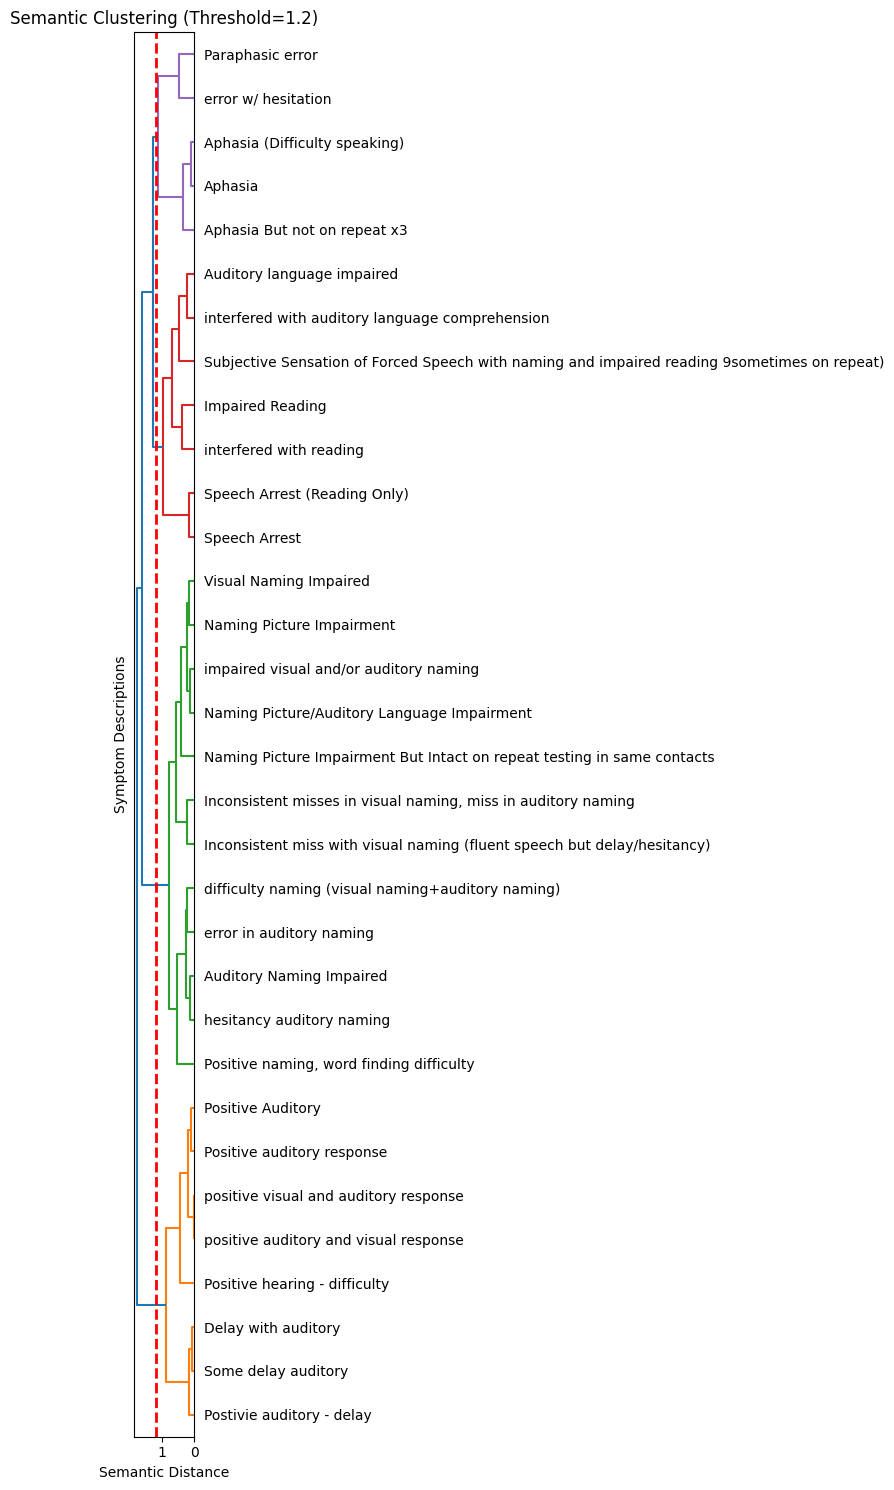

✅ 聚类完成！已在 df_processed 中添加 'Cluster_ID' 列。


,Electrode,Description,Cluster_ID
0,D133-LTMI1,Naming Picture/Auditory Language Impairment,2
1,D133-LTMI2,Naming Picture/Auditory Language Impairment,2
2,D133-LFAP1,Naming Picture Impairment But Intact on repeat...,2
3,D133-LFAP2,Naming Picture Impairment But Intact on repeat...,2
4,D133-LFML12,Naming Picture Impairment,2


In [16]:
# --- 4. 绘制树状图 (竖向列表模式) ---
# figsize=(宽, 高): 这里把高度设为 12 或 15，宽度设为 8，形成一个竖长的图
# 如果你的描述特别多，就把 15 改成 20 或 30
plt.figure(figsize=(8, 15)) 

dendrogram(
    linked,
    labels=unique_descriptions,
    orientation='left',      # <--- 核心修改：改为向左生长 (列表模式)
    leaf_font_size=10,       # 字体大小
    color_threshold=CLUSTER_THRESHOLD
)

# 画出垂直切割线 (注意：现在距离轴变成了 X 轴，所以要画垂直线 axvline)
plt.axvline(x=CLUSTER_THRESHOLD, c='r', linestyle='--', linewidth=2)

plt.title(f'Semantic Clustering (Threshold={CLUSTER_THRESHOLD})')
plt.xlabel("Semantic Distance")    # X轴现在是距离
plt.ylabel("Symptom Descriptions") # Y轴现在是描述列表
plt.tight_layout()
plt.show()

# --- 5. 分配 Cluster ID 并写回表格 ---
cluster_ids = fcluster(linked, CLUSTER_THRESHOLD, criterion='distance')
desc_cluster_map = dict(zip(unique_descriptions, cluster_ids))

# 映射回主表
df_processed['Cluster_ID'] = df_processed['Description'].map(desc_cluster_map)

print("✅ 聚类完成！已在 df_processed 中添加 'Cluster_ID' 列。")
display(df_processed.head())

In [25]:
import sys
import os
import pandas as pd
import matplotlib.colors as mcolors

# ================= 配置区域 =================
sys.path.append(os.path.abspath(os.path.join("..", "..")))
import utils.group as gp

# 🎨 颜色映射配置 (根据你的树状图提取)
# 字典的 Key 是 Cluster_ID，Value 是颜色代码
COLOR_MAP = {
    1: '#ff7f0e',  # 橙色 (对应 Positive Auditory / Bottom group)
    2: '#2ca02c',  # 绿色 (对应 Visual Naming / Middle-Lower group)
    3: '#d62728',  # 红色 (对应 Speech Arrest / Middle-Upper group)
    4: '#9467bd',  # 紫色 (对应 Aphasia / Top group)
}
# 如果有第5类，给一个默认颜色 (如棕色)
DEFAULT_COLOR = '#8c564b' 
# ===========================================

grouped = df_processed.groupby('Cluster_ID')

print(f"====== 开始处理 {len(grouped)} 个分类 (Mapping + Plotting) ======\n")

auto_generated_code = []

for cluster_id, group in grouped:
    # 1. 获取该类下的所有电极 (去重!)
    raw_labels = group['Electrode'].tolist()
    pick_labels = sorted(list(set(raw_labels)))
    
    # 2. 动态提取涉及的病人编号
    extracted_subjs = sorted(list(set([elec.split('-')[0] for elec in pick_labels])))
    
    # 3. 【关键】获取对应颜色
    # 如果 cluster_id 在字典里就用指定颜色，否则用默认颜色
    this_color = COLOR_MAP.get(cluster_id, DEFAULT_COLOR)
    
    # 生成颜色列表 (长度必须匹配去重后的 pick_labels)
    cols_lst = [this_color] * len(pick_labels)
    
    # 4. 自动命名逻辑
    try:
        most_common_desc = group['Description'].mode()[0]
    except:
        most_common_desc = "Unknown"
    
    clean_name = str(most_common_desc).replace("'", "").replace('"', "").strip()
    short_name = clean_name[:30]
    
    # 5. 打印信息
    print(f"🔵 Cluster {cluster_id}: {short_name}...") 
    print(f"   🎨 使用颜色: {this_color}")
    print(f"   🧠 涉及病人: {extracted_subjs}")
    print(f"   ⚡ 电极数量: {len(pick_labels)} (原始: {len(raw_labels)})")
    
    # 6. 调用绘图函数
    print(f"   ...正在绘制脑图...")
    try:
        # 传入去重后的电极和对应的颜色列表
        gp.plot_brain(extracted_subjs, pick_labels, cols_lst, None, 'none', 0.5, 0.2, hemi='lh')
        gp.plot_brain(extracted_subjs, pick_labels, cols_lst, None, 'none', 0.5, 0.2, hemi='rh')
    except Exception as e:
        print(f"   ❌ 绘图失败: {e}")
    
    print("-" * 60)
    
    # 7. 收集命名代码
    auto_generated_code.append(f"    {cluster_id}: '{short_name}',  # {clean_name}")

# --- 生成命名代码块 ---
print("\n" + "="*20 + " 🚀 复制下方代码到 Cell 4 " + "="*20)
print("cluster_names = {")
for line in auto_generated_code:
    print(line)
print("}")
print("\n# df_processed['Category'] = df_processed['Cluster_ID'].map(cluster_names)")

====== 开始处理 4 个分类 (Mapping + Plotting) ======

🔵 Cluster 1: Positive Auditory...
   🎨 使用颜色: #ff7f0e
   🧠 涉及病人: ['D112', 'D117']
   ⚡ 电极数量: 29 (原始: 34)
   ...正在绘制脑图...
False
False
------------------------------------------------------------
🔵 Cluster 2: Visual Naming Impaired...
   🎨 使用颜色: #2ca02c
   🧠 涉及病人: ['D112', 'D115', 'D124', 'D133', 'D138', 'D140']
   ⚡ 电极数量: 32 (原始: 32)
   ...正在绘制脑图...
False
False
------------------------------------------------------------
🔵 Cluster 3: Speech Arrest...
   🎨 使用颜色: #d62728
   🧠 涉及病人: ['D129', 'D134', 'D137']
   ⚡ 电极数量: 17 (原始: 22)
   ...正在绘制脑图...
False
False
------------------------------------------------------------
🔵 Cluster 4: Aphasia...
   🎨 使用颜色: #9467bd
   🧠 涉及病人: ['D112', 'D134', 'D140']
   ⚡ 电极数量: 14 (原始: 16)
   ...正在绘制脑图...
False
False
------------------------------------------------------------

==================== 🚀 复制下方代码到 Cell 4 ====================
cluster_names = {
    1: 'Positive Auditory',  # Positive Auditory
    2: 'Visual 